# CS445: Computational Photography
## Final Project: GIF Video Face Replacement


## Recovering HDR Radiance Maps 

Load libraries and data

In [1]:
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%load_ext autoreload
%autoreload 2

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# modify to where you store your project data including utils
datadir = "/Users/patrick/CS445/Project_Final/"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
imagesfn = datadir + "images"
!cp -r "$imagesfn" .


cp: ./utils.py and /Users/patrick/CS445/Project_Final/utils.py are identical (not copied).
cp: /Users/patrick/CS445/Project_Final/images: No such file or directory


In [4]:
import ffmpeg
import cv2
import numpy as np
import os
import dlib
from numpy.linalg import svd, inv
import utils
%matplotlib inline
from matplotlib import pyplot as plt

In [81]:
# Split input video into frames for blending
utils.video2imageFolder('/Users/patrick/CS445/Project_Final/samples/snapchat.mp4', 
                        "/Users/patrick/CS445/Project_Final/frames")

Frame count: 166.0


NameError: name 'frameId' is not defined

In [82]:
# Function for loading frames
def load_frames(filepath):
    frames = []
    for filename in os.listdir(filepath):
        img = cv2.imread(os.path.join(filepath,filename))
        if img is not None:
            frames.append(img)
    return frames

In [83]:
# Load Frames
frames.clear()
frames = load_frames("/Users/patrick/CS445/Project_Final/frames")

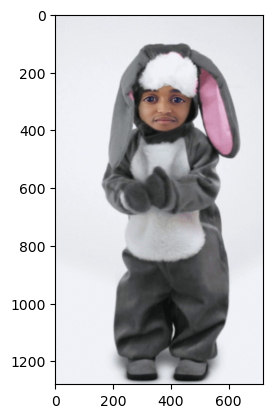

In [84]:
# Testing for one image
test = cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.figure()
plt.imshow(test)
plt.show()

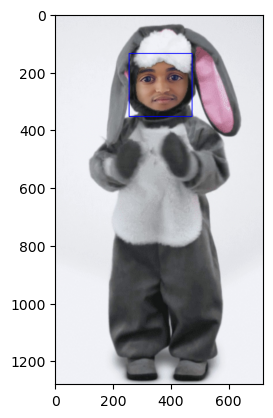

In [85]:
# Testing face detection

# Load the cascade
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Create copy of frame
curr_frame = frames[26].copy()

# Convert into grayscale
gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
# Draw rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(curr_frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
# Display the output
curr_face_detection = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2RGB).astype('double') / 255.0
plt.figure()
plt.imshow(curr_face_detection)
plt.show()

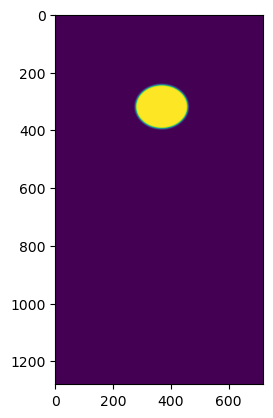

In [88]:
# Mask Process Illustrated

filter_face_bbox = detect_face(frames[0])

mask = create_elliptical_mask(frames[0], filter_face_bbox, kernel_size=(15, 15))
mask = cv2.GaussianBlur(mask, (15, 15), 0)  # Adjust the kernel size for desired feathering
plt.figure()
plt.imshow(mask)
plt.show()

In [10]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def detect_face(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    if len(faces) == 0:
        return None
    return faces[0]  # Assuming one face for simplicity

def get_landmarks(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    for face in faces:
        landmarks = predictor(gray, face)
        return np.array([[p.x, p.y] for p in landmarks.parts()], dtype='float32')
    return None

In [11]:
# Does this consider the chin location and the eyes and warp the face to accomodate for the baby look
def align_faces(source_face, dest_face, src_landmarks, dest_landmarks):
    # Calculate the transformation matrix
    H, _ = cv2.findHomography(src_landmarks, dest_landmarks)
    height, width = dest_face.shape[:2]
    aligned_face = cv2.warpPerspective(source_face, H, (width, height))
    return aligned_face

In [12]:
def create_elliptical_mask(frame, bbox, kernel_size=(15, 15)):
    mask = np.zeros_like(frame, dtype=np.uint8)
    center = (bbox[0] + bbox[2] // 2, bbox[1] + bbox[3] // 2)
    axis_a = bbox[2] // 2  # Width of the ellipse
    axis_b = bbox[3] // 2  # Height of the ellipse

    # Modify the axes to better fit the elliptical shape
    adjusted_axis_a = int(axis_a * 0.9)  # Example adjustment
    adjusted_axis_b = int(axis_b * 0.75)  # Example adjustment
    
    axes = (adjusted_axis_a, adjusted_axis_b)
    cv2.ellipse(mask, center, axes, 0, 0, 360, (255, 255, 255), -1, cv2.LINE_AA)
    # Dilate the mask slightly before blurring
    return cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

def aligned_blending(filter_frame, warped_face, bbox):
    # Create an elliptical mask with softened edges
    mask = create_elliptical_mask(filter_frame, bbox, kernel_size=(15, 15))
    mask = cv2.GaussianBlur(mask, (15, 15), 0)  # Adjust the kernel size for desired feathering

    # Normalize the mask for blending
    alpha_mask = (mask / 255.0).astype(np.float32)
    alpha_mask_3d = cv2.cvtColor(alpha_mask, cv2.COLOR_GRAY2BGR)

    # Use the mask to isolate the face region in the warped face
    face_region = cv2.bitwise_and(warped_face, warped_face, mask=mask)

    # Use the inverse mask to keep the non-face region of the filter frame
    mask_inv = cv2.bitwise_not(mask)
    background = cv2.bitwise_and(filter_frame, filter_frame, mask=mask_inv)

    # Combine the face region and background using weighted blending
    blended = cv2.convertScaleAbs(face_region * alpha_mask_3d + background * (1 - alpha_mask_3d))

    return blended

In [92]:
# Import the face you wish to blend onto the Snapchat filter
face_image = cv2.imread('leon.png')

# Detect and crop the face from the JPG image
face_bbox_jpg = detect_face(face_image)
if face_bbox_jpg is not None:
    face_image_cropped = face_image[face_bbox_jpg[1]:face_bbox_jpg[1]+face_bbox_jpg[3], 
                                    face_bbox_jpg[0]:face_bbox_jpg[0]+face_bbox_jpg[2]]
else:
    print("No face detected in the JPG image.")
    exit()

# Load the Snapchat filter video
cap = cv2.VideoCapture('/Users/patrick/CS445/Project_Final/samples/snapchat.mp4')
processed_frames = []
while True:
    ret, filter_frame = cap.read()
    if not ret:
        break  # Break the loop if no more frames are available

    filter_face_bbox = detect_face(filter_frame)
    if filter_face_bbox is None:
        continue # Skip this frame if the face not detected
    
    top_quarter_height = filter_frame.shape[0] // 4
    if filter_face_bbox[1] + filter_face_bbox[3] // 2 > top_quarter_height:
        continue  # Skip this frame if the face is not in the top quarter
    
    src_landmarks = get_landmarks(face_image_cropped)
    dest_landmarks = get_landmarks(filter_frame)
    if src_landmarks is None or dest_landmarks is None:
        continue # Skip this frame if no landmarks
    # Perform face alignment and blending
    aligned_face = align_faces(face_image_cropped, filter_frame, src_landmarks, dest_landmarks)
    blended_frame = aligned_blending(filter_frame, aligned_face, filter_face_bbox)
    processed_frames.append(cv2.cvtColor(blended_frame, cv2.COLOR_BGR2RGB))
    
output_video_path = '/Users/patrick/CS445/Project_Final/samples/output_video.mp4'
utils.vidwrite_from_numpy(output_video_path, processed_frames, framerate=30)

ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/6.0_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disabl